In [1]:
%cd ..

/Users/jason/repos/diffusion-motion-inbetweening


In [2]:
from convert.joints2bvh import BVH, Animation
from pathlib import Path

In [3]:
# animation = BVH.load("../../data/mixamo/0000_Breakdance_Freezes.bvh")
animation = BVH.load("save/results/condmdi_random_frames/condsamples000750000__benchmark_clip_T=30_CI=0_CRG=0_KGP=1.0_seed10/sample00_rep00_ik.bvh")

In [4]:
animation.positions.shape, animation.rotations.shape

((196, 22, 3), (196, 22))

---

## The following is adapted from `motion_representation.ipynb`

In [5]:
from data_loaders.humanml.common.skeleton import Skeleton
import numpy as np
import os
from data_loaders.humanml.common.quaternion import (
    qbetween_np,
    qrot_np,
    qmul_np,
    qinv_np,
    quaternion_to_cont6d_np,
    qfix,
    qrot,
    qinv,
    quaternion_to_cont6d,
)
from data_loaders.humanml.utils import paramUtil

import torch
from tqdm import tqdm
import os

/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/skeleton.py:2: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  import scipy.ndimage.filters as filters


In [6]:
# Dataset specific globals
joints_num = 22
l_idx1, l_idx2 = 5, 8  # Lower legs
fid_r, fid_l = [8, 11], [7, 10]  # Right/Left foot
face_joint_indx = [2, 1, 17, 16]  # Facing direction, r_hip, l_hip, sdr_r, sdr_l
r_hip, l_hip = 2, 1  # Hips
feet_thre = 0.002

data_dir = './dataset/'
save_dir_joints = './dataset/HumanML3D_temp/new_joints/'
save_dir_vecs = './dataset/HumanML3D_temp/new_joint_vecs/'
# os.makedirs(save_dir_joints, exist_ok=True)
# os.makedirs(save_dir_vecs, exist_ok=True)

n_raw_offsets = torch.from_numpy(paramUtil.t2m_raw_offsets)
kinematic_chain = paramUtil.t2m_kinematic_chain

# Get offsets of target skeleton
example_id = "000021"
example_data = np.load(os.path.join(data_dir, example_id + '.npy'))
example_data = example_data.reshape(len(example_data), -1, 3)
example_data = torch.from_numpy(example_data)
tgt_skel = Skeleton(n_raw_offsets, kinematic_chain, 'cpu')
# (joints_num, 3)
tgt_offsets = tgt_skel.get_offsets_joints(example_data[0])
# print(tgt_offsets)

In [7]:
def uniform_skeleton(positions, target_offset):
    """Adjusts the scale to match the reference skeleton.
    Returns the properly scaled joint positions.

    1. Get source and target joint offsets
    2. Calculate a scaling ratio to uniform source and target skeletons
    3. Scale the source root positions accordingly
    4. Get the source rotations using IK
    5. Apply these rotations together with the scaled root positions using FK
    6. Return the new joint positions
    """

    src_skel = Skeleton(n_raw_offsets, kinematic_chain, 'cpu')
    src_offset = src_skel.get_offsets_joints(torch.from_numpy(positions[0]))
    src_offset = src_offset.numpy()
    tgt_offset = target_offset.numpy()
    # print(src_offset)
    # print(tgt_offset)
    '''Calculate Scale Ratio as the ratio of legs'''
    src_leg_len = np.abs(src_offset[l_idx1]).max() + np.abs(src_offset[l_idx2]).max()
    tgt_leg_len = np.abs(tgt_offset[l_idx1]).max() + np.abs(tgt_offset[l_idx2]).max()

    scale_rt = tgt_leg_len / src_leg_len
    # print(scale_rt)
    src_root_pos = positions[:, 0]
    tgt_root_pos = src_root_pos * scale_rt

    '''Inverse Kinematics'''
    quat_params = src_skel.inverse_kinematics_np(positions, face_joint_indx)
    # print(quat_params.shape)

    '''Forward Kinematics'''
    src_skel.set_offset(target_offset)
    new_joints = src_skel.forward_kinematics_np(quat_params, tgt_root_pos)
    return new_joints


In [8]:
def process_file(positions, feet_thre):
    # (seq_len, joints_num, 3)
    #     '''Down Sample'''
    #     positions = positions[::ds_num]

    '''Uniform Skeleton'''
    positions = uniform_skeleton(positions, tgt_offsets)

    '''Put on Floor'''
    floor_height = positions.min(axis=0).min(axis=0)[1]
    positions[:, :, 1] -= floor_height

    '''XZ at origin'''
    root_pos_init = positions[0]
    root_pose_init_xz = root_pos_init[0] * np.array([1, 0, 1])
    positions = positions - root_pose_init_xz

    # '''Move the first pose to origin '''
    # root_pos_init = positions[0]
    # positions = positions - root_pos_init[0]

    '''All initially face Z+'''
    r_hip, l_hip, sdr_r, sdr_l = face_joint_indx
    across1 = root_pos_init[r_hip] - root_pos_init[l_hip]
    across2 = root_pos_init[sdr_r] - root_pos_init[sdr_l]
    across = across1 + across2
    across = across / np.sqrt((across ** 2).sum(axis=-1))[..., np.newaxis]

    # forward (3,), rotate around y-axis
    forward_init = np.cross(np.array([[0, 1, 0]]), across, axis=-1)
    # forward (3,)
    forward_init = forward_init / np.sqrt((forward_init ** 2).sum(axis=-1))[..., np.newaxis]

    target = np.array([[0, 0, 1]])
    root_quat_init = qbetween_np(forward_init, target)
    root_quat_init = np.ones(positions.shape[:-1] + (4,)) * root_quat_init

    positions_b = positions.copy()

    positions = qrot_np(root_quat_init, positions)

    '''New ground truth positions'''
    global_positions = positions.copy()

    """ Get Foot Contacts """
    def foot_detect(positions, thres):
        velfactor, heightfactor = np.array([thres, thres]), np.array([3.0, 2.0])

        feet_l_x = (positions[1:, fid_l, 0] - positions[:-1, fid_l, 0]) ** 2
        feet_l_y = (positions[1:, fid_l, 1] - positions[:-1, fid_l, 1]) ** 2
        feet_l_z = (positions[1:, fid_l, 2] - positions[:-1, fid_l, 2]) ** 2
        feet_l = ((feet_l_x + feet_l_y + feet_l_z) < velfactor).astype(np.float32)

        feet_r_x = (positions[1:, fid_r, 0] - positions[:-1, fid_r, 0]) ** 2
        feet_r_y = (positions[1:, fid_r, 1] - positions[:-1, fid_r, 1]) ** 2
        feet_r_z = (positions[1:, fid_r, 2] - positions[:-1, fid_r, 2]) ** 2
        feet_r = (((feet_r_x + feet_r_y + feet_r_z) < velfactor)).astype(np.float32)
        return feet_l, feet_r

    feet_l, feet_r = foot_detect(positions, feet_thre)

    '''Quaternion and Cartesian representation'''
    r_rot = None

    def get_rifke(positions):
        '''Local pose'''
        positions[..., 0] -= positions[:, 0:1, 0]
        positions[..., 2] -= positions[:, 0:1, 2]
        '''All pose face Z+'''
        positions = qrot_np(np.repeat(r_rot[:, None], positions.shape[1], axis=1), positions)
        return positions

    def get_cont6d_params(positions):
        skel = Skeleton(n_raw_offsets, kinematic_chain, "cpu")
        # (seq_len, joints_num, 4)
        quat_params = skel.inverse_kinematics_np(positions, face_joint_indx, smooth_forward=True)

        '''Quaternion to continuous 6D'''
        cont_6d_params = quaternion_to_cont6d_np(quat_params)
        # (seq_len, 4)
        r_rot = quat_params[:, 0].copy()

        '''Root Linear Velocity'''
        # (seq_len - 1, 3)
        velocity = (positions[1:, 0] - positions[:-1, 0]).copy()
        velocity = qrot_np(r_rot[1:], velocity)

        '''Root Angular Velocity'''
        # (seq_len - 1, 4)
        r_velocity = qmul_np(r_rot[1:], qinv_np(r_rot[:-1]))
        # (seq_len, joints_num, 4)
        return cont_6d_params, r_velocity, velocity, r_rot

    cont_6d_params, r_velocity, velocity, r_rot = get_cont6d_params(positions)
    positions = get_rifke(positions)

    '''Root height'''
    root_y = positions[:, 0, 1:2]

    '''Root rotation and linear velocity'''
    # (seq_len-1, 1) rotation velocity along y-axis
    # (seq_len-1, 2) linear velovity on xz plane
    r_velocity = np.arcsin(r_velocity[:, 2:3])
    l_velocity = velocity[:, [0, 2]]
    root_data = np.concatenate([r_velocity, l_velocity, root_y[:-1]], axis=-1)

    '''Get Joint Rotation Representation'''
    # (seq_len, (joints_num-1) *6) quaternion for skeleton joints
    rot_data = cont_6d_params[:, 1:].reshape(len(cont_6d_params), -1)

    '''Get Joint Rotation Invariant Position Represention'''
    # (seq_len, (joints_num-1)*3) local joint position
    ric_data = positions[:, 1:].reshape(len(positions), -1)

    '''Get Joint Velocity Representation'''
    # (seq_len-1, joints_num*3)
    local_vel = qrot_np(np.repeat(r_rot[:-1, None], global_positions.shape[1], axis=1),
                        global_positions[1:] - global_positions[:-1])
    local_vel = local_vel.reshape(len(local_vel), -1)

    data = root_data
    data = np.concatenate([data, ric_data[:-1]], axis=-1)
    data = np.concatenate([data, rot_data[:-1]], axis=-1)
    data = np.concatenate([data, local_vel], axis=-1)
    data = np.concatenate([data, feet_l, feet_r], axis=-1)

    return data, global_positions, positions, l_velocity


In [9]:
# Recover global angle and positions for rotation data
# root_rot_velocity (B, seq_len, 1)
# root_linear_velocity (B, seq_len, 2)
# root_y (B, seq_len, 1)
# ric_data (B, seq_len, (joint_num - 1)*3)
# rot_data (B, seq_len, (joint_num - 1)*6)
# local_velocity (B, seq_len, joint_num*3)
# foot contact (B, seq_len, 4)
def recover_root_rot_pos(data, return_rot_ang=False):
    rot_vel = data[..., 0]
    r_rot_ang = torch.zeros_like(rot_vel).to(data.device)
    '''Get Y-axis rotation from rotation velocity'''
    r_rot_ang[..., 1:] = rot_vel[..., :-1]
    r_rot_ang = torch.cumsum(r_rot_ang, dim=-1)

    r_rot_quat = torch.zeros(data.shape[:-1] + (4,)).to(data.device)
    r_rot_quat[..., 0] = torch.cos(r_rot_ang)
    r_rot_quat[..., 2] = torch.sin(r_rot_ang)

    r_pos = torch.zeros(data.shape[:-1] + (3,)).to(data.device)
    r_pos[..., 1:, [0, 2]] = data[..., :-1, 1:3]
    '''Add Y-axis rotation to root position'''
    r_pos = qrot(qinv(r_rot_quat), r_pos)

    r_pos = torch.cumsum(r_pos, dim=-2)

    r_pos[..., 1] = data[..., 3]

    if return_rot_ang:
        return r_rot_quat, r_pos, r_rot_ang
    return r_rot_quat, r_pos


In [10]:
def get_abs_data_from_joints(filepath: Path):
    source_data = np.load(filepath)
    f_frame, f_joints = source_data.shape[:2]
    print(f"Loaded file with {f_frame} frames and {f_joints} number of joints.")
    if f_joints > joints_num:
        print(f"Keeping only the first {joints_num} joints.")
        source_data = source_data[:, :joints_num]

    ### compute absolute root information instead of relative, ignore rec_ric_data
    rel_data, ground_positions, positions, l_velocity = process_file(source_data, 0.002)

    r_rot_quat, r_pos, rot_ang = recover_root_rot_pos(torch.from_numpy(rel_data), return_rot_ang=True)
    abs_data = rel_data.copy()
    abs_data[:, 0] = rot_ang
    abs_data[:, [1, 2]] = r_pos[:, [0,2]]

    return abs_data

In [11]:
abs_data = get_abs_data_from_joints(Path("../HumanML3D/joints/004185.npy"))
abs_data.shape

Loaded file with 154 frames and 52 number of joints.
Keeping only the first 22 joints.


/Users/jason/repos/diffusion-motion-inbetweening/data_loaders/humanml/common/quaternion.py:394: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194305/work/aten/src/ATen/native/Cross.cpp:66.)
  v = torch.cross(v0, v1)


(153, 263)

---


1. Load BVH
2. Extract the Positions
3. Re-order the joints
4. Continue with `get_abs_data_from_joints` (more or less)
5. Normalize the data
6. Profit!

In [12]:
# filepath = Path("save/results/condmdi_random_frames/condsamples000750000__benchmark_clip_T=30_CI=0_CRG=0_KGP=1.0_seed10/sample00_rep00_ik.bvh")
filepath = Path("sample/dummy.bvh")
bvh_anim : Animation = BVH.load(filepath)

In [13]:
bvh_anim.parents

array([-1,  0,  1,  2,  3,  0,  5,  6,  7,  0,  9, 10, 11, 12, 11, 14, 15,
       16, 11, 18, 19, 20])

In [15]:
# from humanml/utils/paramUtil.py
t2m_kinematic_chain = [[0, 2, 5, 8, 11], [0, 1, 4, 7, 10], [0, 3, 6, 9, 12, 15], [9, 14, 17, 19, 21], [9, 13, 16, 18, 20]]

# from joints2bvh_condmdi.py
re_order     = [0, 1, 4, 7, 10, 2, 5, 8, 11, 3, 6, 9, 12, 15, 13, 16, 18, 20, 14, 17, 19, 21]
re_order_inv = [0, 1, 5, 9, 2, 6, 10, 3, 7, 11, 4, 8, 12, 14, 18, 13, 15, 19, 16, 20, 17, 21]

In [23]:
pos = Animation.positions_global(bvh_anim)[:, re_order_inv]
# pos = bvh_anim.positions[:, re_order_inv]

In [24]:
import matplotlib.pyplot as plt

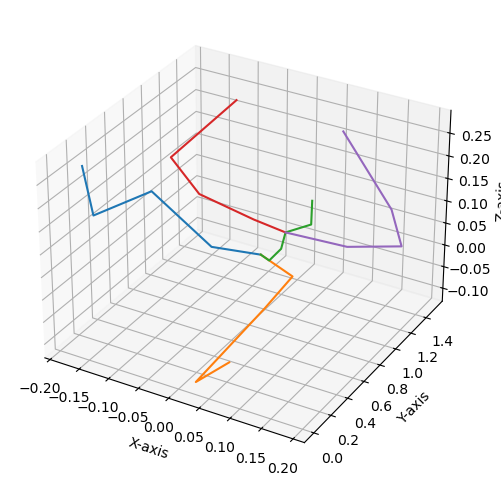

In [25]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

frame = 0
for chain in t2m_kinematic_chain:
    ax.plot3D(
        pos[frame, chain, 0],
        pos[frame, chain, 1],
        pos[frame, chain, 2],
    )

plt.show()

In [26]:
def get_abs_data_from_bvh(filepath: Path):
    bvh_animation = BVH.load(filepath)
    # source_data = bvh_animation.positions
    source_data = Animation.positions_global(bvh_animation)

    ### compute absolute root information instead of relative, ignore rec_ric_data
    rel_data, ground_positions, positions, l_velocity = process_file(source_data, 0.002)

    r_rot_quat, r_pos, rot_ang = recover_root_rot_pos(torch.from_numpy(rel_data), return_rot_ang=True)
    abs_data = rel_data.copy()
    abs_data[:, 0] = rot_ang
    abs_data[:, [1, 2]] = r_pos[:, [0,2]]

    return abs_data


In [27]:
abs_data_bvh = get_abs_data_from_bvh(filepath)
abs_data_bvh.shape

(195, 263)

In [1]:
# Normalize with `dataloader.dataset.mean` and `dataloader.dataset.std`
# or `dataloader.dataset.t2m_dataset.transform_th(...)`